In [8]:
import os
import re
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse
from typing import List, Optional, Dict, Any, TypedDict
from langchain_community.tools import ShellTool  # (if needed for shell commands)
from langgraph.graph import StateGraph, END, START

In [9]:
# --- Step 1: Define the Recursive Crawl State ---
class RecursiveCrawlState(TypedDict):
    current_url: str                    # URL to crawl
    current_depth: int                  # Current recursion depth
    max_depth: int                      # Max recursion depth allowed
    discovered_links: List[str]         # All links discovered so far
    visited_urls: List[str]             # To prevent re-crawling same URL
    error_message: Optional[str]        # Error message, if any
    html_content: Optional[str]         # HTML content of the current page

In [10]:
# --- Step 2: Define Workflow Nodes ---

# Node 1: Fetching the Web Page
def fetch_page_node(state: RecursiveCrawlState) -> RecursiveCrawlState:
    print("--- NODE: Fetching the web page... ---")
    updates: Dict[str, Optional[str]] = {"error_message": None}

    current_url = state.get("current_url")
    if not current_url:
        updates["error_message"] = "Error: No URL provided."
        return updates

    try:
        print(f"Fetching the web page: {current_url}")
        response = requests.get(current_url)
        response.raise_for_status()  # Raise an error for invalid responses
        updates["html_content"] = response.text
        print(f"Page fetched successfully: {current_url}")
    except requests.exceptions.RequestException as e:
        updates["error_message"] = f"Error fetching page: {str(e)}"

    return updates

In [11]:
# Node 2: Extracting Links
def extract_links_node(state: RecursiveCrawlState) -> RecursiveCrawlState:
    print("--- NODE: Extracting links from the web page... ---")
    updates: Dict[str, Optional[Any]] = {"error_message": None}

    html_content = state.get("html_content")
    if not html_content:
        updates["error_message"] = "Error: No HTML content available to extract links."
        return updates

    try:
        soup = BeautifulSoup(html_content, 'html.parser')
        links = set()  # Set to avoid duplicates
        for anchor in soup.find_all('a', href=True):
            link = anchor.get('href')
            full_url = urljoin(state.get("current_url"), link)
            links.add(full_url)
        updates["discovered_links"] = list(links)
        print(f"Extracted {len(links)} links.")
    except Exception as e:
        updates["error_message"] = f"Error extracting links: {str(e)}"

    return updates

In [12]:
# Node 3: Validating Links
def validate_links_node(state: RecursiveCrawlState) -> RecursiveCrawlState:
    print("--- NODE: Validating links... ---")
    updates: Dict[str, Optional[Any]] = {"error_message": None}

    discovered_links = state.get("discovered_links", [])
    visited_urls = state.get("visited_urls", [])

    valid_links = []
    for link in discovered_links:
        # Avoid revisiting URLs
        if link not in visited_urls:
            # Basic validation to check if URL is well-formed
            if urlparse(link).scheme and urlparse(link).netloc:
                valid_links.append(link)

    updates["valid_links"] = valid_links
    print(f"Validated {len(valid_links)} links.")
    return updates

In [13]:
# Node 4: Recursion/Depth Handling
def recursion_node(state: RecursiveCrawlState) -> RecursiveCrawlState:
    print("--- NODE: Handling recursion... ---")
    updates: Dict[str, Optional[str]] = {"error_message": None}

    current_depth = state.get("current_depth", 0)
    max_depth = state.get("max_depth", 3)
    valid_links = state.get("valid_links", [])

    # If maximum depth is reached, stop recursion
    if current_depth >= max_depth:
        print(f"Maximum depth of {max_depth} reached. Stopping recursion.")
        return updates

    # Recursively crawl valid links
    for link in valid_links:
        if link not in state["visited_urls"]:
            state["visited_urls"].append(link)
            print(f"Recursively crawling: {link}")
            updates["current_url"] = link
            updates["current_depth"] = current_depth + 1
            break
    else:
        print("No new links to crawl.")
        updates["current_url"] = None  # End recursion if no new links to crawl

    return updates

In [14]:
# --- Step 3: Build the Workflow Graph ---
workflow = StateGraph(RecursiveCrawlState)

workflow.add_node("fetch_page", fetch_page_node)
workflow.add_node("extract_links", extract_links_node)
workflow.add_node("validate_links", validate_links_node)
workflow.add_node("recursion", recursion_node)

workflow.set_entry_point("fetch_page")

In [15]:
# --- Step 4: Define Conditional Edges for the Workflow ---

# Condition after fetching the page
def decide_after_fetching(state: RecursiveCrawlState) -> str:
    if state.get("error_message") or not state.get("html_content"):
        print(f"--- Condition: Error during page fetch: {state.get('error_message')}, ending workflow. ---")
        return END
    else:
        print("--- Condition: Page fetched successfully, proceeding to link extraction. ---")
        return "extract_links"

workflow.add_conditional_edges(
    "fetch_page",
    decide_after_fetching,
    {
        "extract_links": "extract_links",
        END: END
    }
)

In [16]:
# Condition after extracting links
def decide_after_extraction(state: RecursiveCrawlState) -> str:
    if state.get("error_message") or not state.get("discovered_links"):
        print(f"--- Condition: Error during link extraction: {state.get('error_message')}, ending workflow. ---")
        return END
    else:
        print("--- Condition: Links extracted successfully, proceeding to link validation. ---")
        return "validate_links"

workflow.add_conditional_edges(
    "extract_links",
    decide_after_extraction,
    {
        "validate_links": "validate_links",
        END: END
    }
)

In [18]:
# Condition after validating links
def decide_after_validation(state: RecursiveCrawlState) -> str:
    if state.get("error_message") or not state.get("valid_links"):
        print(f"--- Condition: Error during link validation: {state.get('error_message')}, ending workflow. ---")
        return END
    else:
        print("--- Condition: Links validated successfully, proceeding to recursion (crawling next link). ---")
        return "recursion"

workflow.add_conditional_edges(
    "validate_links",
    decide_after_validation,
    {
        "recursion": "recursion",
        END: END
    }
)

In [19]:
# Final step: Exit when no more links to crawl
workflow.add_edge("recursion", END)

In [20]:
# --- Step 5: Run the Workflow ---

In [21]:
# Execute the workflow
app = workflow.compile()

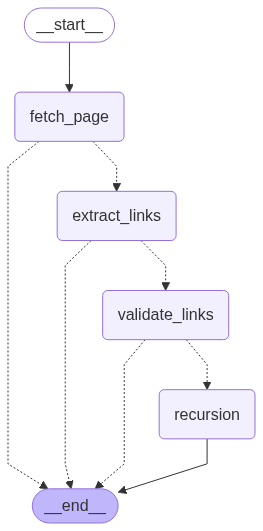

In [22]:
# Display graph
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

In [24]:
# Example initial state
initial_state = {
    "current_url": "https://dreamhack.io/",   # Starting URL
    "current_depth": 0,                     # Start from depth 0
    "max_depth": 3,                         # Maximum recursion depth
    "discovered_links": [],
    "visited_urls": []
}

try:
    final_state = app.invoke(initial_state)

    # Output results
    print("\n--- Crawling Result ---")
    if final_state.get("error_message"):
        print(f"❌ Error occurred: {final_state.get('error_message')}")
    else:
        print(f"✔️ Crawling completed. Discovered URLs: {len(final_state.get('discovered_links'))}")
        print("   Discovered URLs: ")
        print(final_state.get("discovered_links"))

except Exception as e:
    print(f"💥 Exception occurred: {str(e)}")

--- NODE: Fetching the web page... ---
Fetching the web page: https://dreamhack.io/
Page fetched successfully: https://dreamhack.io/
--- Condition: Page fetched successfully, proceeding to link extraction. ---
--- NODE: Extracting links from the web page... ---
Extracted 38 links.
--- Condition: Links extracted successfully, proceeding to link validation. ---
--- NODE: Validating links... ---
Validated 38 links.
--- Condition: Error during link validation: None, ending workflow. ---

--- Crawling Result ---
✔️ Crawling completed. Discovered URLs: 38
   Discovered URLs: 
['https://dreamhack.io/services/tos', 'https://dreamhack.io/lecture', 'https://dreamhack.io/ctf', 'https://dreamhack.io/myaccount/contact', 'https://dreamhack.io/forum', 'https://dreamhack.io/payments/membership-pricing?redirect=%2F&referer=index-after-subscription-promotion-plan', 'https://www.youtube.com/v/TggmzKJ9x_A', 'https://dreamhack.io/career/home', 'https://dreamhack.io/payments/membership-pricing?redierct=%2F&